Automate e-commerce processes with image classification.\
Fashion Forward is a new AI-based e-commerce clothing retailer. They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.


In [295]:
!pip install torchmetrics
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [296]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall

import matplotlib.pyplot as plt

In [297]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [298]:
print(type(train_data))
print(train_data.class_to_idx)
print(f"Number of images: {len(train_data)}")
print(f"Number of classes: {len(train_data.classes)}")

num_classes = len(train_data.classes)

<class 'torchvision.datasets.mnist.FashionMNIST'>
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
Number of images: 60000
Number of classes: 10


torch.Size([1, 28, 28])
tensor(3)


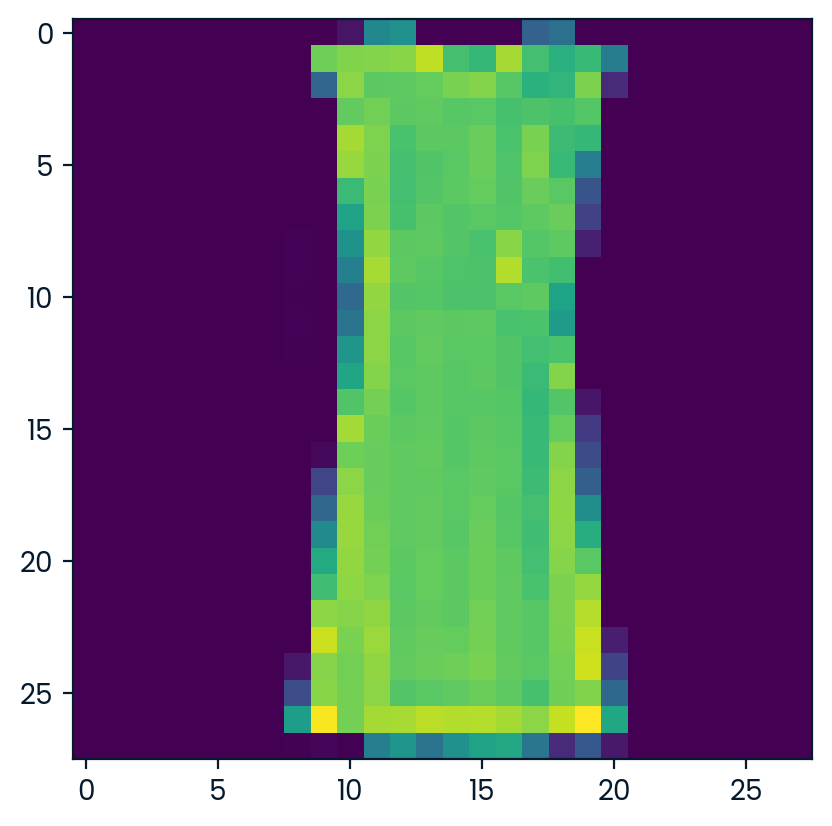

torch.Size([28, 28])


In [299]:
# Train DataLoader
dataloader_train = DataLoader(train_data, shuffle =True, batch_size = 10)

images, labels = next(iter(dataloader_train))  
image = images[0]
label = labels[0]
# image, label = train_data[0]

print(image.shape)    # 1: batch size, 1: one color channel, 28 * 28: H * W
print(label)

image = image.squeeze()    # image = image.squeeze(0).permute(1, 2, 0)
plt.imshow(image)
plt.show()
print(image.shape)

# Multi-Class CNN:

In [300]:
class MultiClassCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_exteractor = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        # Fully Connected Layer for Classification
        self.fc = nn.Linear(16 * 14 * 14, num_classes)
        # self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        x = self.feature_exteractor(x)
        x = self.fc(x)
        # x = self.softmax(x)
        return x

# TRAINING LOOP

In [301]:
cnn = MultiClassCNN(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)

nbr_epochs = 2
for i in range(nbr_epochs):
    for images, labels in dataloader_train:  # dataloader's batch size=10 ==> images & labels are both of size 10
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [302]:
print(outputs.shape)

torch.Size([10, 10])


# EVALUATION LOOP (TEST)

In [303]:
# Test DataLoader
dataloader_test = DataLoader(test_data, shuffle = False, batch_size = 10)

# Metrics
accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes)
precision_metric = Precision(task='multiclass', num_classes=num_classes, average=None)
recall_metric = Recall(task='multiclass', num_classes=num_classes, average=None)

# Evaluation Loop
cnn.eval()
predictions = []
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = cnn(images) # cnn(images.reshape(-1, 1, 28, 28)), in this case: predicted_classes = torch.argmax(outputs, dim=-1) (change dim to -1 in the next line)
        _, predicted_classes = torch.max(outputs, dim=1)   # max_values, max_indices(predicted_classes (idx))
        accuracy_metric(predicted_classes, labels)
        precision_metric(predicted_classes, labels)
        recall_metric(predicted_classes, labels)
        
        predictions.extend(predicted_classes.tolist())   # required a predictions list

In [304]:
print(outputs.shape)
print(predicted_classes.shape)
print(predicted_classes)

print(len(predictions))

torch.Size([10, 10])
torch.Size([10])
tensor([5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
10000


In [305]:
# Metrics
accuracy = accuracy_metric.compute().item()
precision = precision_metric.compute().tolist()
recall = recall_metric.compute().tolist()

print(accuracy)
print(precision)
print(recall)

0.8682000041007996
[0.7537190318107605, 0.9788306355476379, 0.862604558467865, 0.8927125334739685, 0.6501035094261169, 0.9794450402259827, 0.8151751160621643, 0.9375619292259216, 0.9641076922416687, 0.9443902373313904]
[0.9120000004768372, 0.9710000157356262, 0.722000002861023, 0.8820000290870667, 0.9419999718666077, 0.953000009059906, 0.4189999997615814, 0.9459999799728394, 0.9670000076293945, 0.9679999947547913]
